# Simple Cosmic Rays Experiment (Part II)

<font size="3">The target of this notebook is generate events for the $\Delta t$ distribution by using a Monte Carlo method as well as obtaining values for $N$ and $\tau$ parameters by fitting an exponential function to data distribution. We take two cases to simulate, one is when the MC events are bigger than $T_{dead} = 220$ ms and the other case is by taking events from 0 ms, i.e, full events.</font>

## Setting the environment

In [6]:
#version: 20-APR-2023
from ROOT import *
import numpy as np
import math

#MC parameters

N_MC_EVENTS_GEN = 100000 #Generating 100000 MC events
TAU   = 103.8 # [ms]
DEAD_TIME = 220.0 #[ms]

## --- time between events
N_bins_Dt = 100
X_MIN_Dt =    0.0
X_MAX_Dt = 1000.0 #// [ms]

#Histograms for both cases
h_MC_Dt = TH1F("h_MC_Dt","h_MC_Dt;#Delta t (ms); #events",N_bins_Dt,X_MIN_Dt,X_MAX_Dt);
h_MC_FULL_Dt = TH1F("h_MC_FULL_Dt","h_MC_FULL_Dt;#Delta t (ms); #events",N_bins_Dt,X_MIN_Dt,X_MAX_Dt)

Warning in <TROOT::Append>: Replacing existing TH1: h_MC_Dt (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_MC_FULL_Dt (Potential memory leak).


## Generating MC data

In [7]:
%%time 

#Starting to count accepted events with dt > Tdead
i_acc=0

dt_sum = DEAD_TIME #time spend until the end of dead time gate, first event is always accepted

#Generate mane random numbers in one go
dt = np.random.default_rng().exponential(TAU, N_MC_EVENTS_GEN)

#Calculate cumulative sum of dead time = total elapsed time
exposure_time = 0.0

MC_TIME =[]

#Loop over the generated events
for aEvent in dt:
    dt_sum += aEvent #time spend in current dead time gate
    h_MC_FULL_Dt.Fill(dt_sum);
    exposure_time += aEvent
    
    if dt_sum >= DEAD_TIME: 
        i_acc+=1
        MC_TIME.append(exposure_time)
        dt_sum = 0.0 #start new dead time gate
        
# calculate dead time fraction (two methods)
tot_dead_time = i_acc*DEAD_TIME
dead_time_frac = tot_dead_time/exposure_time

print("gen_MC: N_gen = ", N_MC_EVENTS_GEN)
print("gen_MC: N_acc = " ,i_acc)
print( "gen_MC: i_exposure_time [ms] = " ,exposure_time)
print("gen_MC: tau       = ",TAU)
print("gen_MC: dead_time = " , DEAD_TIME)
print("gen_MC: dead_time_frac  = " , dead_time_frac )
print( "gen_MC: 1 - N_acc/N_gen = ",1.0 - i_acc/N_MC_EVENTS_GEN) 

gen_MC: N_gen =  100000
gen_MC: N_acc =  32054
gen_MC: i_exposure_time [ms] =  10342904.972830653
gen_MC: tau       =  103.8
gen_MC: dead_time =  220.0
gen_MC: dead_time_frac  =  0.6818084492243031
gen_MC: 1 - N_acc/N_gen =  0.67946
CPU times: user 197 ms, sys: 24 ms, total: 221 ms
Wall time: 219 ms


## Filling histogram for $\Delta t > T_{dead}$

In [8]:
rolled = np.roll(MC_TIME, shift=-1)

#calculate difference between rows
dst_delta = rolled - MC_TIME

#remove the last element
dst_delta = dst_delta[:-1]

print("Original data array:\n", MC_TIME[0:5])
print("Rolled data array:\n", rolled[0:5])
print("Difference: \n",dst_delta[0:5])

#Fill the histogram
for aItem in dst_delta:
    h_MC_Dt.Fill(aItem)

Original data array:
 [40.47294879488429, 292.0489396246079, 655.663460914124, 950.518387424584, 1178.8158444019004]
Rolled data array:
 [ 292.04893962  655.66346091  950.51838742 1178.8158444  1417.48436491]
Difference: 
 [251.57599083 363.61452129 294.85492651 228.29745698 238.66852051]


## Fitting and plotting the histogram for $\Delta t > T_{dead}$

<font size="3"> In analogous way as in data notebook (PI_DATA_dt) we fit an exponential function $f(t)$ to our MC data. For a discrete case, the next expression establish the number of events in the $\Delta t$ distribution from $T_{dead}=220$ ms to 1000 ms:  </font>

 <font size="4"> $N_{events}= \sum_{n=0}^{N_{bins}} N \cdot W \cdot p(t_n) = \sum_{n=0}^{N_{bins}} f(t_n)$ </font>

<font size="3"> where $N$ is taken as a proportional constant, $W$ is the width of the histogram bins and <font size="4">$P(t)= \frac{1}{\tau} e^{-t/\tau}$. </font>

naive_f_td  =  0.8828202838944811
proper_f_td =  0.6819385451369021
Value of    N: 273619.853887
Value of    tau: 102.609715
Value of    NFD: 76.000000
Value of    Chi2: 82.307362
 FCN=39.8484 FROM MIGRAD    STATUS=CONVERGED      88 CALLS          89 TOTAL
                     EDM=3.20658e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.73620e+05   3.65769e+03   6.28225e+00  -6.41199e-09
   2  tau          1.02610e+02   5.82011e-01   1.06700e-03  -1.08600e-05
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv1


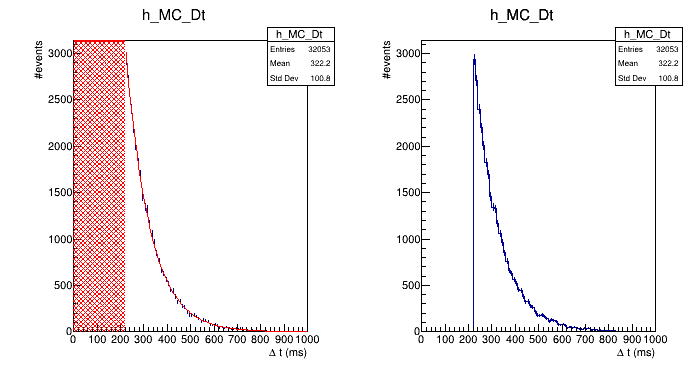

In [9]:
#Values for fitting
XEPS = 4.0; #// [ms]
bin_w = h_MC_Dt.GetXaxis().GetBinWidth(1)

#Initial values for fitting
N_evt = 20000.0
tau   =   100.0

## Exponential fitting

s_func_exp = str(bin_w)+"*([0]/[1]*exp(-x/[1]))"
f_func_exp    =  TF1("Exp"     ,s_func_exp    ,DEAD_TIME, X_MAX_Dt) #DEAD_TIME-XEPS

f_func_exp.SetParName(0,"N")
f_func_exp.SetParameter(0,N_evt)
  

f_func_exp.SetParName(1,"tau")
f_func_exp.SetParameter(1,tau)

h_MC_Dt.Fit("Exp","0L","",DEAD_TIME,X_MAX_Dt)

##Constant fitting

#we use the parameters value obtained from the exponential fitting to calculate the constant value
N     = f_func_exp.GetParameter(0);
tau   = f_func_exp.GetParameter(1);

s_func_const = str(bin_w) + "*([0]/[1]*exp(-[2]/[1]))"
f_func_const    = TF1("Const"     ,s_func_const    ,0.0, DEAD_TIME)

f_func_const.SetParameter(0,N)
f_func_const.SetParameter(1,tau)
f_func_const.SetParameter(2,DEAD_TIME) # ie.: DEAD_TIME

## calculate fraction of dead time

naive_f_td = 1.0 - exp(-DEAD_TIME/tau);
proper_f_td = DEAD_TIME/(tau + DEAD_TIME);


print("naive_f_td  = ", naive_f_td)
print("proper_f_td = " ,proper_f_td )

########################################
##Plotting the histograms and function##
########################################

canv1 = TCanvas("canv1","canv1",700,400)
canv1.Divide(2,1)

aPad = canv1.cd(1)
aPad.SetLeftMargin(0.2)
f_func_exp.SetLineColor(kRed);
f_func_exp.SetLineWidth(1);
f_func_exp.SetLineStyle(1); # 1 == solid, 2 == dashed, 3 == dotted
f_func_exp.DrawCopy();

f_func_const.SetLineColor(kRed);
f_func_const.SetFillColor(kRed);
f_func_const.SetLineWidth(2);
f_func_const.SetLineStyle(1); # 1 == solid, 2 == dashed, 3 == dotted
f_func_const.SetFillStyle(3344); # 1 == solid, 2 == dashed, 3 == dotted
f_func_const.DrawCopy();
  
# plot once again DATA to have 'bullets' on top of histos and fitted functions

h_MC_Dt.Draw("ex0")
f_func_exp.Draw("same")
f_func_const.Draw("same");
canv1.Draw()

aPad = canv1.cd(2)
aPad.SetLeftMargin(0.2)
h_MC_Dt.Draw("e0 hist")

print ('Value of    N: {0:2f}'.format(N))
print ('Value of    tau: {0:2f}'.format(tau))
print ('Value of    NFD: {0:2f}'.format(f_func_exp.GetNDF()))
print ('Value of    Chi2: {0:2f}'.format(f_func_exp.GetChisquare()))

## Fitting and plotting histogram for full time 

naive_f_td  =  0.8828247946601495
proper_f_td =  0.6819424393790137
Value of    N: 273638.915580
Value of    tau: 102.607873
Value of    NFD: 76.000000
Value of    Chi2: 82.298408
 FCN=39.8455 FROM MIGRAD    STATUS=CONVERGED      90 CALLS          91 TOTAL
                     EDM=3.67853e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            2.73639e+05   3.65792e+03   6.28233e+00  -5.83091e-09
   2  tau          1.02608e+02   5.81987e-01   1.06691e-03  -4.11497e-06
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv2


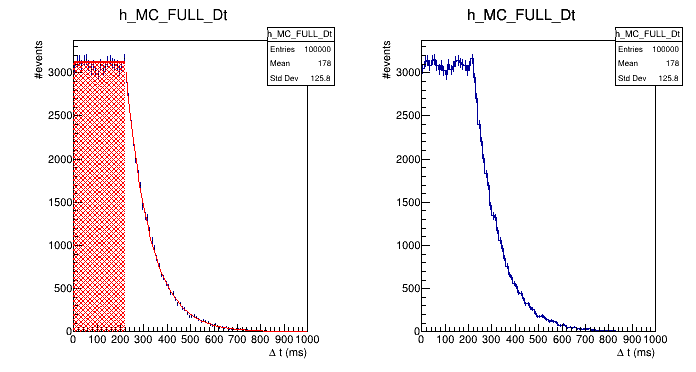

In [10]:
#Values for fitting
bin_w = h_MC_FULL_Dt.GetXaxis().GetBinWidth(1)
N_evt = 20000.0
tau   =   100.0

## Exponential function

f_func_exp.SetParName(0,"N")
f_func_exp.SetParameter(0,N_evt)
  

f_func_exp.SetParName(1,"tau")
f_func_exp.SetParameter(1,tau)

h_MC_FULL_Dt.Fit("Exp","0L","",DEAD_TIME,X_MAX_Dt)

##Constant function

N     = f_func_exp.GetParameter(0);
tau   = f_func_exp.GetParameter(1);

s_func_const = str(bin_w) + "*([0]/[1]*exp(-[2]/[1]))"
f_func_const    = TF1("Const"     ,s_func_const    ,0.0, DEAD_TIME)

f_func_const.SetParameter(0,N)
f_func_const.SetParameter(1,tau)
f_func_const.SetParameter(2,DEAD_TIME) # ie.: DEAD_TIME

## calculate fraction of dead time

naive_f_td = 1.0 - exp(-DEAD_TIME/tau);
proper_f_td = DEAD_TIME/(tau + DEAD_TIME);

print("naive_f_td  = ", naive_f_td)
print("proper_f_td = " ,proper_f_td )


########################################
##Plotting the histograms and function##
########################################
canv2 = TCanvas("canv2","canv2",700,400)
canv2.Divide(2,1)

aPad = canv2.cd(1)
aPad.SetLeftMargin(0.2)
f_func_exp.SetLineColor(kRed);
f_func_exp.SetLineWidth(1);
f_func_exp.SetLineStyle(1); # 1 == solid, 2 == dashed, 3 == dotted
f_func_exp.DrawCopy();

f_func_const.SetLineColor(kRed);
f_func_const.SetFillColor(kRed);
f_func_const.SetLineWidth(2);
f_func_const.SetLineStyle(1); # 1 == solid, 2 == dashed, 3 == dotted
f_func_const.SetFillStyle(3344); # 1 == solid, 2 == dashed, 3 == dotted
f_func_const.DrawCopy();
  
# plot once again DATA to have 'bullets' on top of histos and fitted functions

h_MC_FULL_Dt.Draw("ex0")
f_func_exp.Draw("same")
f_func_const.Draw("same");
canv2.Draw()

aPad = canv2.cd(2)
aPad.SetLeftMargin(0.2)
h_MC_FULL_Dt.Draw("e0 hist")

print ('Value of    N: {0:2f}'.format(N))
print ('Value of    tau: {0:2f}'.format(tau))
print ('Value of    NFD: {0:2f}'.format(f_func_exp.GetNDF()))
print ('Value of    Chi2: {0:2f}'.format(f_func_exp.GetChisquare()))